The input file are read and the contained routes are transformed into monopartite, reactions only, SynGraph objects. To simplify the analysis, in this example we considered only 6 routes predicted by each CASP tool, randomly selected.

In [10]:
import json
from linchemin.interfaces.facade import facade

input_dict = {
        'data/IBMRXN_routes.json': 'ibm_retro',
        'data/AZ_routes.json': 'az_retro',
        'data/ASCKOS_routes.json': 'mit_retro',
    }
all_routes = []
for file, casp in input_dict.items():
    graph = json.loads(open(file).read())[:6]
    output, _ = facade('translate', input_format=casp, input_list=graph, out_data_model='monopartite_reactions')
    print(f'{len(output)} routes randomly selected among those predicted by {casp}')
    all_routes.extend(output)
print(f'In total, there are {len(all_routes)} routes predicted')


6 routes randomly selected among those predicted by ibm_retro
6 routes randomly selected among those predicted by az_retro
6 routes randomly selected among those predicted by mit_retro
In total, there are 18 routes predicted


Using the uid property of the SynGraph object, we can isolate the unique routes from the initial dataset

In [11]:
unique_initial_routes = []
for route in all_routes:
    if route not in unique_initial_routes:
        unique_initial_routes.append(route)
print('number of unique routes in the initial dataset= ', len(unique_initial_routes))


number of unique routes in the initial dataset=  18


In order to correctly assess the number of unique routes based on the identity of only reactants and products, the reactions involved in each route are mapped using atom-to-atom mapping tools

In [12]:
from linchemin.cheminfo.atom_mapping import perform_atom_mapping
from linchemin.cgu.syngraph_operations import extract_reactions_from_syngraph
from linchemin.cgu.syngraph import MonopartiteReacSynGraph

def atom_mapping(route_list: list, mapper=None) -> list:
    """ Performs the atom mapping of a list of chemical equations smiles """
    mapped_routes: list = []
    for route in route_list:
        reaction_list = extract_reactions_from_syngraph(route)
        out = perform_atom_mapping(reaction_list, mapper_name=mapper)
        syngraph = MonopartiteReacSynGraph(out.mapped_reactions)
        mapped_routes.append(syngraph)
    return mapped_routes or None

In [13]:
mapped_routes = atom_mapping(unique_initial_routes, mapper='rxnmapper')
unique_routes = []
for route in mapped_routes:
    if route not in unique_routes:
        unique_routes.append(route)
        
print('number of unique routes after mapping = ', len(unique_routes))

number of unique routes after mapping =  17


Additional spurious routes can be removed by identifying subsets

In [14]:
subsets = facade("subsets", unique_routes)
for item in subsets:
    route_to_remove = next((r for r in unique_routes if r.uid == item[0]), None)
    if route_to_remove and route_to_remove in unique_routes:
        unique_routes.remove(route_to_remove)
print('number of unique routes after removing subsets = ', len(unique_routes))

number of unique routes after removing subsets =  16


Single route manipulation: node removal and addition

In [15]:
from linchemin.cgu.syngraph_operations import remove_reaction_from_syngraph, add_reaction_to_syngraph

route = unique_routes[11]

node_to_remove = (f'[CH3:17][C:16]([CH3:18])([CH3:19])[O:14][C:13](=[O:15])[NH:12][C:3]1=[CH:2][CH:1]=[C:6]'
                  f'([CH:5]=[CH:4]1)[C:9]1=[N:10][O:11][CH:7]=[N:8]1'
                  f'>>[NH2:12][C:3]1=[CH:2][CH:1]=[C:6]([CH:5]=[CH:4]1)[C:9]1=[N:10][O:11][CH:7]=[N:8]1')
new_route_removal = remove_reaction_from_syngraph(syngraph=route, reaction_to_remove=node_to_remove, remove_dandling_nodes=True)


node_to_add = (f'CC[O:3][C:2](=[O:1])[CH:4]1[CH2:5][CH2:6][S:7]'
               f'(=[O:8])(=[O:9])[CH2:10][CH2:11]1'
               f'>>[O:1]=[C:2]([OH:3])[CH:4]1[CH2:5][CH2:6][S:7](=[O:8])(=[O:9])[CH2:10][CH2:11]1')
new_route_addition = add_reaction_to_syngraph(syngraph=route, reaction_to_add=node_to_add)


Now we can proceed with the route mining. The function to mine routes already return only unique routes.

In [16]:
from linchemin.cgu.route_mining import mine_routes

root = 'Cc1cccc(C)c1N(CC(=O)Nc1ccc(-c2ncon2)cc1)C(=O)C1CCS(=O)(=O)CC1'
mined_routes = mine_routes(unique_routes, root)
print(f'{len(mined_routes)} unique routes were mined')


150 unique routes were mined


We can check the routes' descriptors to assess the complexity of the predicted vs mined routes.

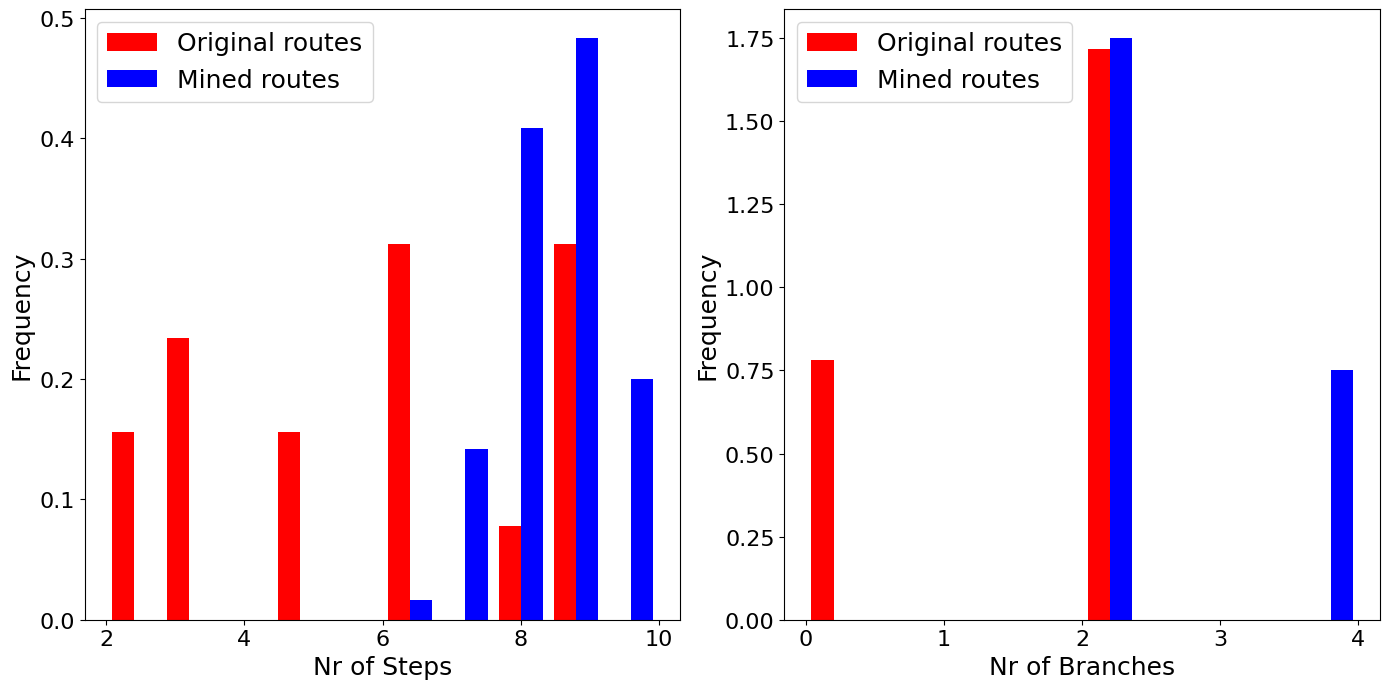

In [17]:
import matplotlib.pyplot as plt
from linchemin.rem.route_descriptors import descriptor_calculator

original_lengths = sorted([len(r.graph) for r in unique_routes])
original_branches = sorted([descriptor_calculator(r, 'nr_branches') for r in unique_routes])
mined_lengths = sorted([len(r.graph) for r in mined_routes])
mined_branches = sorted([descriptor_calculator(r, 'nr_branches') for r in mined_routes])

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
labels = ['Original routes', 'Mined routes']

ax1.hist([original_lengths, mined_lengths], histtype='bar', density=True, color=['red', 'blue'], label=labels)
ax1.set_ylabel('Frequency', fontsize=18)
ax1.set_xlabel('Nr of Steps', fontsize=18)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(labels, fontsize=18)
ax2.hist([original_branches, mined_branches], histtype='bar', density=True, color=['red', 'blue'], label=labels)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xlabel('Nr of Branches', fontsize=18)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.legend(labels, fontsize=18)
# Show plot
fig.tight_layout()
plt.show()


In [18]:
only_mined_routes = [route for route in mined_routes if route not in unique_routes]
print(f'{len(only_mined_routes)} routes were extracted that were not present in the original (cleaned) dataset')

145 routes were extracted that were not present in the original (cleaned) dataset
